<center>
<p><img src="https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png" width="100">
</p>

# **Análisis exploratorio de un grupo de Whatsapp**
## Maestría en Ciencia de Datos
#### Ortega Tanori, Esthefania
#### 01 / Octubre / 2025


</center>

¿Cómo se comporta un determinado grupo de Whatsapp? ¿Qué temas son los que más se hablan? ¿Quién habla más? 

Esas preguntas y muchas más se pueden responder facilmente a partir de un rápido análisis exploratorio de datos con diferentes librerías y funciones de Python, como se demuestra a continuación.

## Preparación
Comenzamos instalando las librerías necesarias:

In [ ]:
#!pip install spacy
#!pip install "numpy<2"
#!pip install --upgrade numpy pandas seaborn wordcloud

In [3]:
#Para importar nuestros datos
import zipfile

#Para dar formato de tabla
import pandas as pd

#Para analisis de texto
import re

#Para visualización
import seaborn as sns
import matplotlib.pyplot as plt

#Para utilizar una API
import requests


In [5]:
#Establecemos un estilo y formato general para visualizar nuestros datos en gráficas
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('bmh')

A continuación, se definieron dos funciones importantes: 
* **anonimiza_hp()** - una función anonimizadora que regresa nombres de la franquicia de Harry Potter
* **datos_whatsapp(texto)** - una función que analiza el historial de chat en formato string para identificar cada mensaje y extraer sus características (fecha, hora, remitente, contenido, tipo de mensaje y cantidad de palabras que contiene)

In [7]:
#Obtenemos nombres de una API de personajes de Harry Potter para anonimizar los miembros del grupo de Whatsapp
def anonimiza_hp():
    try:
        #URL de la API
        api_url = 'https://hp-api.onrender.com/api/characters'
        #Enviamos un request de tipo GET
        response = requests.get(api_url)
        #Leemos la respuesta de la api en formato JSON
        nombres = response.json()
        return nombres

    #En caso de error en conexión, imprimir una alerta
    except requests.exceptions.RequestException:
        print("Error al conectarse a la API")
        return []

In [9]:
def datos_whatsapp(texto):

    #Establecemos un patrón que nuestros mensajes siguen y capturamos por partes (3 para ser concretos)
    #1 : Fecha en formato (dia/mes/año), día y mes pueden ser de 1 o 2 dígitos y año es de 4 dígitos
    #\s+ captura espacios
    #2: Hora (.*) Nos da el resto de la línea hasta topar con otro espacio \s+ y un guión -
    #3: Resto del mensaje
    pattern = r'(\d{1,2}/\d{1,2}/\d{4}),\s+(.*?)\s+-\s+(.*)'
    
    #Busca coincidencias en nuestro texto del patrón y la almacena en la variable matches (cada instancia corresponde a un mensaje)
    matches = re.findall(pattern, texto, re.MULTILINE)

    #Inicializamos la variable de tipo lista donde almacenaremos la información de cada mensaje como una lista anidada
    data = []
    #Variables para anonimizar
    lista_anon = {} 
    nombres_hp = anonimiza_hp()

    #Itera sobre cada elemento (correspondiente a un mensaje) en matches
    for match in matches:
        #Asigna a las variables las 3 partes que buscamos en el patrón
        fecha, hora, resto_linea = match
        miembro = ""
        mensaje = ""

        # Dividimos el resto de la línea para separar miembro/autor y mensaje, SOLO SI hay dos puntos.
        if ':' in resto_linea:
            # Dividimos la cadena en dos a partir del caracter :
            partes = resto_linea.split(':', 1)
            miembro = partes[0].strip()  # El miembro es la primera parte
            mensaje = partes[1].strip()  # El mensaje es la segunda parte
            if re.fullmatch(r'\s*', mensaje): #Buscamos mensajes vacíos
                tipo_msj = 'multimedia' #Cuando se envían varias imágenes o imágenes de una sola vez, en el historial aparece como un mensaje vacio
            else:
                tipo_msj = 'texto' #Por defecto, nuestro tipo de mensaje es de texto
        else:
            # Si no hay ':', es un mensaje de sistema
            miembro = 'Sistema'  # Asignamos un miembro/autor Sistema
            mensaje = resto_linea.strip() # El mensaje es la línea completa
            tipo_msj = 'Sistema' # Lo definimos como mensaje de sistema
        
        
        #Anonimización de miembros
        #random.shuffle(nombres_hp) #Para hacer aleatorios los nombres ficticios
        miembro_anon = ""
        
        if miembro in lista_anon:
            miembro_anon = lista_anon[miembro]
        else: 
            if miembro == 'Sistema':
                miembro_anon = 'Sistema'
            else:
                indice = len(lista_anon) - 1
                if indice < len(nombres_hp):
                    miembro_anon = nombres_hp[indice]['name']
                else:
                    miembro_anon = f"Mago Desconocido #{indice_actual - len(nombres_personajes) + 1}"
            
            lista_anon[miembro] = miembro_anon
        
        # Para la clasificación de tipo de mensajes, buscamos frases concretas en ellos
        if '<multimedia omitido>' in mensaje.lower():
            tipo_msj = 'multimedia'
        if ('se eliminó este mensaje' in mensaje.lower()) or ('eliminaste' in mensaje.lower()):
            tipo_msj = 'eliminado'

        #Para contar cuantas palabras contiene el mensaje
        if tipo_msj == 'texto':
            conteo_palabras = len(mensaje.split())
        else:
            conteo_palabras = 0

        #Finalmente, adjuntamos la informacion recabada a nuestra variable data
        #data.append([fecha, hora, miembro, mensaje, tipo_msj, conteo_palabras]) #Datos sin anonimizar
        data.append([fecha, hora, miembro_anon, mensaje, tipo_msj, conteo_palabras])

    return data

## Importación de datos y definición de formato
Ahora que ya definimos nuestra metodología de lectura y extracción, podemos proceder a la importación de datos

In [15]:
#Definimos donde se encuentra nuestro archivo de datos y cómo se llama
zip_path = './data/chat_whatsapp.zip'
archivo = 'Chat de WhatsApp.txt'

#Leemos nuestro archivo y decodificamos
try: 
    zf = zipfile.ZipFile(zip_path)
    info= zf.open(archivo).read().decode('utf-8')

#En caso de no poder leer el archivo
except FileNotFoundError:
    print(f"El archivo .zip '{zip_path}' no se encuentra.")
except Exception as e:
    print(f"Ocurrió un error: {e}")

#Le damos un formato de dataframe a nuestra información
df = pd.DataFrame(datos_whatsapp(info), columns = ['fecha', 'hora', 'miembro', 'mensaje','tipo_msj', 'conteo_palabras'])

#Definimos nuestras variables datetime
df['fecha'] = pd.to_datetime(df['fecha'], format = '%d/%m/%Y')
df['hora'] = df['hora'].astype(str)
df['hora'] = df['hora'].str.replace(r'\s+|[.]', '', regex=True)
df['hora'] = pd.to_datetime(df['hora'], format = '%I:%M%p').dt.time
df['tipo_msj'] = df['tipo_msj'].astype('category')
df.sample(n = 5)

,fecha,hora,miembro,mensaje,tipo_msj,conteo_palabras
23853,2021-07-24,13:24:00,Cho Chang,Está lloviendo para allá?,texto,4
58643,2025-09-11,11:46:00,Hermione Granger,La plancha si sirve,texto,4
49895,2025-01-16,16:29:00,Severus Snape,Un strudel de manzanaa es menos dañino... y un...,texto,11
25883,2021-11-15,18:06:00,Hermione Granger,<Multimedia omitido>,multimedia,0
36698,2022-11-10,08:52:00,Severus Snape,<Multimedia omitido>,multimedia,0


¿Cómo se ve nuestro dataframe?

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59481 entries, 0 to 59480
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   fecha            59481 non-null  datetime64[ns]
 1   hora             59481 non-null  object        
 2   miembro          59481 non-null  object        
 3   mensaje          59481 non-null  object        
 4   tipo_msj         59481 non-null  category      
 5   conteo_palabras  59481 non-null  int64         
dtypes: category(1), datetime64[ns](1), int64(1), object(3)
memory usage: 2.3+ MB


Al no tener valores faltantes y verificar que todo está clasificado adecuadamente, podemos iniciar nuestro análisis

## Análisis exploratorio

Veamos las características valores estadísticos generales de nuestro grupo

In [19]:
fecha_inicio = df['fecha'].min()
fecha_final = df['fecha'].max()
rango_tiempo = fecha_final - fecha_inicio
total_mensajes = len(df)
total_miembros = df['miembro'].nunique()
promedio_msj_dia = int(total_mensajes / rango_tiempo.days)
promedio_palabras_msj = df[(df['miembro'] != 'Sistema') & (df['tipo_msj'] == 'texto')]['conteo_palabras'].mean()
print(f"Los datos obtenidos son del {fecha_inicio:%d/%m/%Y} al {fecha_final:%d/%m/%Y}, comprendiendo un rango de tiempo de {rango_tiempo.days} días, aproximadamente {int(rango_tiempo.days/365)} años")
print(f"En el grupo han colaborado {total_miembros} miembros")
print(f"El total de mensajes en el chat es de {total_mensajes}")
print(f"El promedio de mensajes por día es de {promedio_msj_dia} mensajes")
print(f"Con un promedio de {round(promedio_palabras_msj, 1)} palabras por mensaje")

Los datos obtenidos son del 24/09/2015 al 29/09/2025, comprendiendo un rango de tiempo de 3658 días, aproximadamente 10 años
En el grupo han colaborado 11 miembros
El total de mensajes en el chat es de 59481
El promedio de mensajes por día es de 16 mensajes
Con un promedio de 5.9 palabras por mensaje


### ¿Quiénes son los principales colaboradores del grupo?
Analizemos la cantidad de mensajes enviados por cada miembro del grupo gráficamente

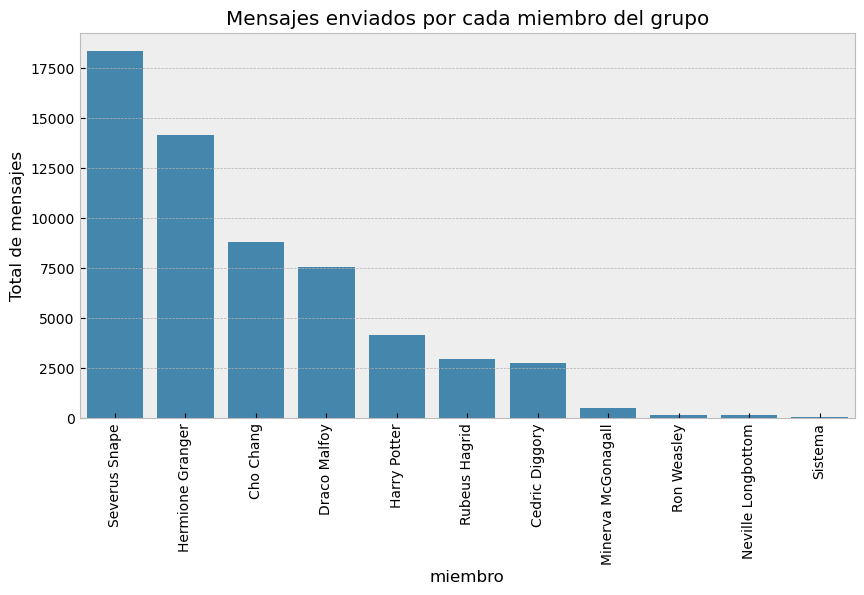

In [21]:
orden_msjs = df['miembro'].value_counts().index

plt.xticks(rotation = 90)
sns.countplot(data = df, x = 'miembro', order = orden_msjs)
plt.ylabel('Total de mensajes')
plt.title('Mensajes enviados por cada miembro del grupo')
plt.show()

### ¿Cómo se ve la actividad del grupo en el transcurso del día?

Analizamos cuántos mensajes se envían a cada hora del día

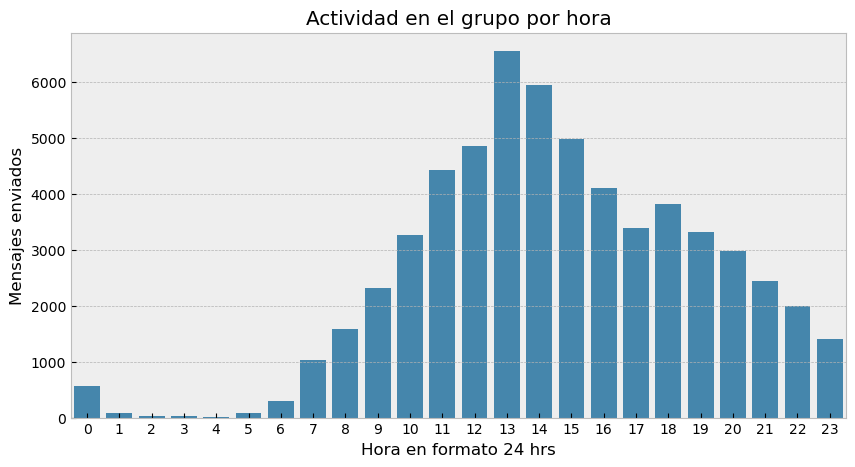

In [23]:
df['hora_hora'] = df['hora'].astype(str)
df['hora_hora'] = df['hora_hora'].str.findall(r'^\d{2}').str[0].astype(int)

sns.countplot(data = df, x = 'hora_hora')
plt.title('Actividad en el grupo por hora')
plt.ylabel('Mensajes enviados')
plt.xlabel('Hora en formato 24 hrs')
plt.show()

Entre 12 y 3 P.M. se envía la mayor cantidad de mensajes, esto corresponde con la hora de la comida, es posible que los miembros busquen conversar mientras comen

Entre 1 y 5 A.M. se muestra la menor actividad, esto ya que posiblemente los miembros estén durmiendo

## ¿Y a qué hora se envían los mensajes más largos?
Analicemos el promedio de cantidad de palabras por mensaje por hora

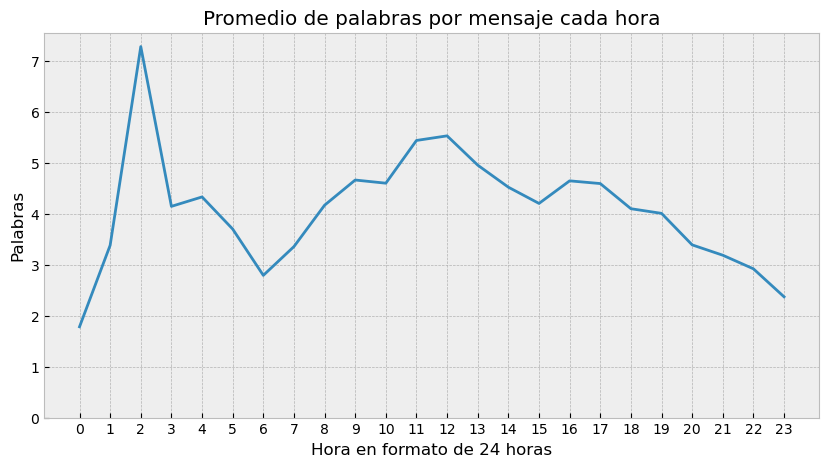

In [25]:
mensajes_hora = df.groupby('hora_hora')['conteo_palabras'].mean()
sns.lineplot(data = mensajes_hora)
plt.title('Promedio de palabras por mensaje cada hora')
plt.ylabel('Palabras')
plt.xlabel('Hora en formato de 24 horas')
plt.xticks(ticks = mensajes_hora.index)
plt.ylim(0)
plt.show()

El promedio en general de palabras por mensaje es pequeño, pero a las 2 A.M. se alcanzó un promedio máximo de más de 7 palabras ¿es posible que las personas les guste conversar en su insomnio?

### ¿Cómo ha cambiado la actividad a través de los años?

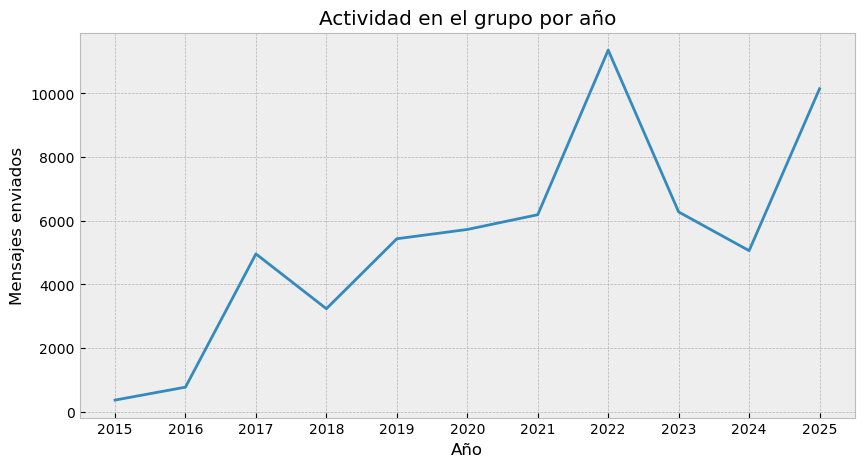

In [27]:
actividad_anual = df.groupby(df['fecha'].dt.year).size()
sns.lineplot(data = actividad_anual)

plt.xticks(ticks = actividad_anual.index)
plt.title('Actividad en el grupo por año')
plt.ylabel('Mensajes enviados')
plt.xlabel('Año')
plt.show()

El año con mayor actividad fue en el **2022**, podríamos indagar en qué situaciones particulares sucedieron ese año que pudieran haber potencializado ese pico de actividad. La tendencia indica que el año actual (**2025**) podría alcanzar la misma cantidad de mensajes enviados ¿qué puede estar provocando este pico? 

### ¿Cómo se comporta en el transcurso de un año?

Podemos desglosar la cantidad de mensajes recibidos en cada mes y analizar qué meses son los más activos

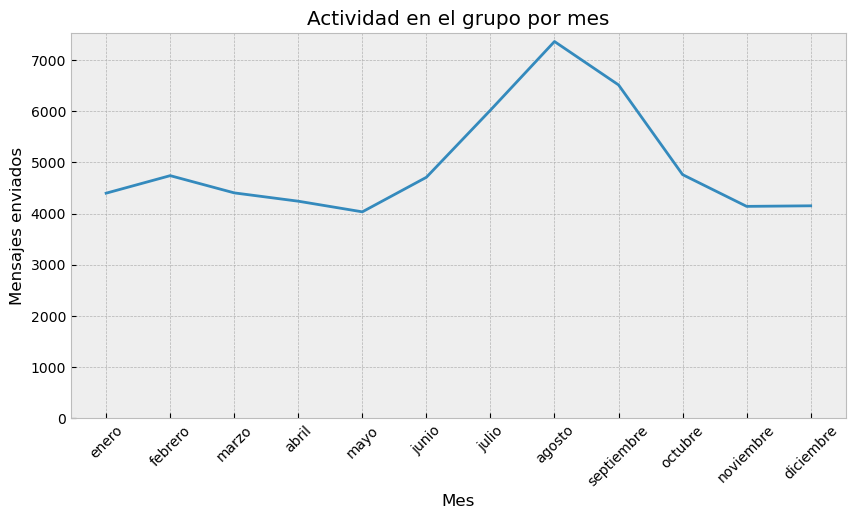

In [29]:
meses = {1: 'enero',
         2: 'febrero',
         3: 'marzo',
         4: 'abril',
         5: 'mayo',
         6: 'junio',
         7: 'julio',
         8: 'agosto',
         9: 'septiembre',
         10: 'octubre',
         11: 'noviembre',
         12: 'diciembre'
        }

actividad_mensual = df.groupby(df['fecha'].dt.month).size()

sns.lineplot(data = actividad_mensual)
plt.xticks(ticks = actividad_mensual.index, labels = meses.values(), rotation = 45)
plt.ylim(0)
plt.ylabel('Mensajes enviados')
plt.xlabel('Mes')
plt.title('Actividad en el grupo por mes')
plt.show()

Los meses de **julio a septiembre** son los que registran mayor actividad a comparación del resto del año, esto coincide con el fin de verano e inicio de clases, así como el cumpleaños de varios de los miembros, por lo que es posible que aumente la cantidad de mensajes y envío de multimedia.

Fuera de ese pico, parece ser que la cantidad de mensajes recibido en el resto de los meses es bastante similar.

### ¿Cómo es la actividad durante la semana? 
Analicemos las cantidad de mensajes por día de la semana

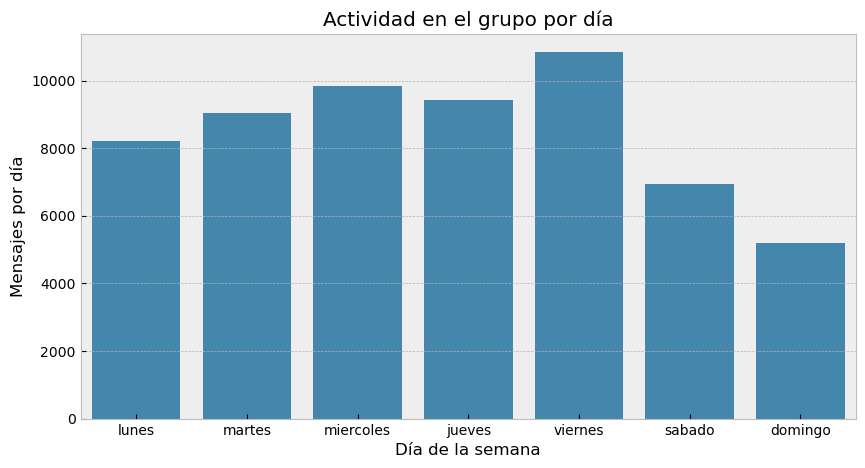

In [31]:
semana = {0: 'lunes',
          1: 'martes',
          2: 'miercoles',
          3: 'jueves',
          4: 'viernes',
          5: 'sabado',
          6: 'domingo'}
df['dia'] = df['fecha'].dt.weekday.map(semana)
sns.countplot(data = df, x = 'dia', order = ['lunes', 'martes', 'miercoles', 'jueves', 'viernes', 'sabado', 'domingo'])
plt.ylabel('Mensajes por día')
plt.xlabel('Día de la semana')
plt.title('Actividad en el grupo por día')
plt.show()

### Estadísticas de cada miembro
¿Cuánto participa cada miembro y cómo lo suele hacer?

In [33]:
actividad_miembro = df.groupby('miembro').agg(tot_msj_miembro = ('mensaje', 'count'), 
                                              dias_activos = ('fecha', 'nunique'), 
                                              palabras_promedio = ('conteo_palabras','mean'), 
                                              msj_mas_largo = ('conteo_palabras', 'max'),
                                              msjs_eliminados = ('tipo_msj', lambda x: (x == 'eliminado').sum()),
                                              msjs_multimedia = ('tipo_msj', lambda x: (x == 'multimedia').sum())
                                             )
actividad_miembro['promedio_msj_dia'] = actividad_miembro['tot_msj_miembro'] / actividad_miembro['dias_activos']
actividad_miembro['porcentaje_multimedia'] = (actividad_miembro['msjs_multimedia']/actividad_miembro['tot_msj_miembro'])*100

actividad_miembro.sort_values('tot_msj_miembro', ascending = False)

,tot_msj_miembro,dias_activos,palabras_promedio,msj_mas_largo,msjs_eliminados,msjs_multimedia,promedio_msj_dia,porcentaje_multimedia
miembro,,,,,,,,
Severus Snape,18330,1438,5.229514,165,53,6685,12.746871,36.470267
Hermione Granger,14155,1960,3.082868,62,27,2761,7.221939,19.505475
Cho Chang,8772,1358,4.564181,134,32,2234,6.459499,25.467396
Draco Malfoy,7533,938,5.683526,314,19,1576,8.030917,20.921280
Harry Potter,4144,669,4.038610,186,8,645,6.194320,15.564672
Rubeus Hagrid,2947,314,3.688497,111,5,546,9.385350,18.527316
Cedric Diggory,2724,637,2.842878,62,6,482,4.276295,17.694567
Minerva McGonagall,482,105,2.232365,21,0,60,4.590476,12.448133
Ron Weasley,168,19,5.541667,28,0,15,8.842105,8.928571


Hay tres miembros (Severus, Hermione y Cho) con mayor cantidad de días activos, lo cual también coincide con los miembros que han enviado mensajes, esto puede ser a que tienen mayor antigüedad en el grupo, ya que hay otros miembros con un mayor promedio de mensajes por día (Draco, Rubeus y Ron) pero menor cantidad de días activos. 

Curiosamente, la persona que envía más mensajes por día en promedio, también elimina más mensajes y envía más multimedia en proporción al total de mensajes que envía. 

Draco Malfoy, quien tiene la mayor cantidad de palabras promedio por mensaje, también ha enviado el mensaje más largo (de 314 palabras!)

La segunda persona que envía más mensajes, tiene una menor cantidad de palabras promedio por mensaje a comparación del primer y tercer lugar (¿cantidad sobre calidad?) y su mensaje más largo es el más corto del top 6

### ¿Qué suele enviar cada miembro?

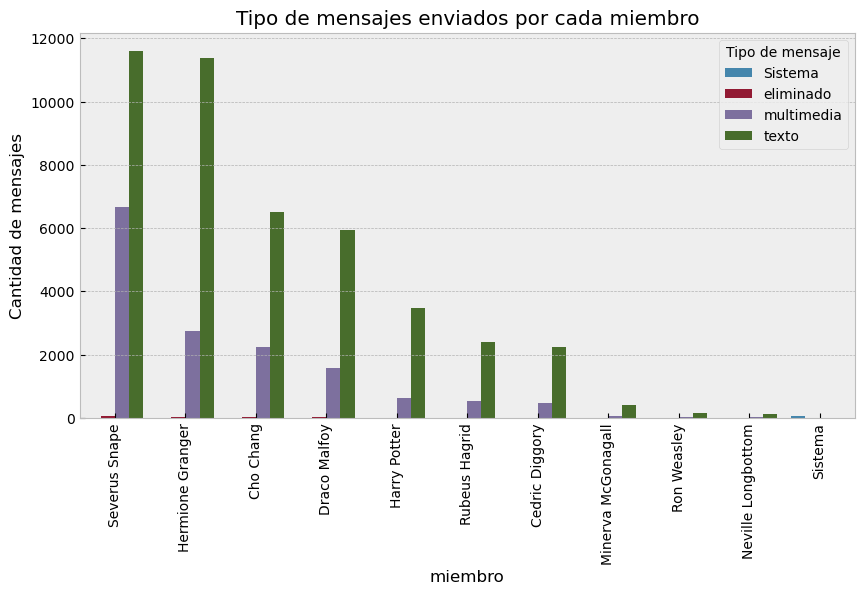

In [35]:
ax = sns.countplot(data = df, x = 'miembro', hue = 'tipo_msj', order = orden_msjs)

ax.get_legend().set_title('Tipo de mensaje')
plt.xticks(rotation = 90)
plt.ylabel('Cantidad de mensajes')
plt.title('Tipo de mensajes enviados por cada miembro')
plt.show()

Podemos observar que Hermione envía una cantidad similar de mensajes de texto a Severus Snape, sin embargo, la cantidad de multimedia que envía es significativamente menor

### ¿Qué es lo que más se envía?
Analicemos los tipos de mensaje

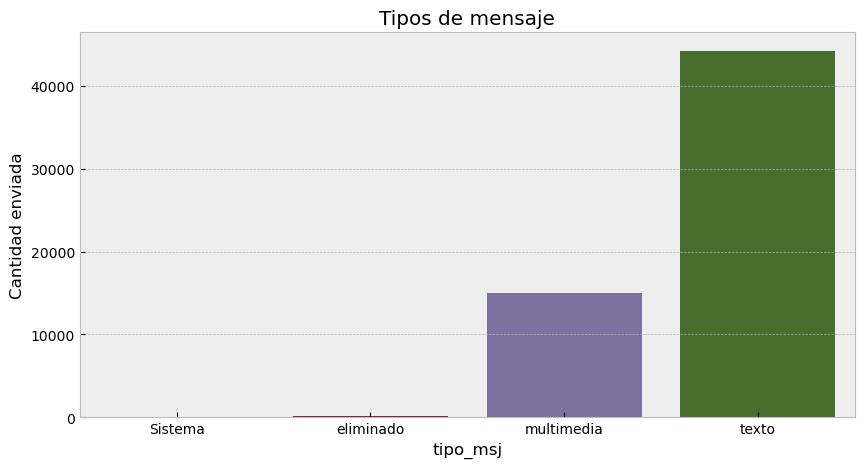

In [37]:
sns.countplot(data = df, x = 'tipo_msj', hue = 'tipo_msj')
plt.title('Tipos de mensaje')
plt.ylabel('Cantidad enviada')
plt.show()

En este grupo, se envían más mensajes de texto que multimedia, y si es así ¿de qué se habla comúnmente? ¡Veamos!

### ¿Qué se habla?

¿Qué palabras son las más utilizadas en el grupo? ¿Nos puede esto indicar qué utilidad se le da en general?

Crearemos una nube de palabras para averiguarlo.

In [ ]:
#!python -m spacy download es_core_news_md

In [33]:
#Creamos una máscara para hacer más atractiva nuestra nube de palabras
import urllib.request
from PIL import Image
import numpy as np

#Escogemos una imagen de burbuja de chat
file_img = "textbubble.jpg"
img_url = "https://img.freepik.com/premium-vector/vector-chat-bubble-white-background_921039-3230.jpg"
urllib.request.urlretrieve(img_url, file_img)

# Cargamos la imagen y la convertimos a un array de numpy
mask = np.array(Image.open(file_img))

# The mask should be a binary image where white pixels (255) indicate where words can be placed
# and black pixels (0) indicate where they cannot. Adjust this based on your image.
mask[mask < 150] = 0
mask[mask >= 150] = 255

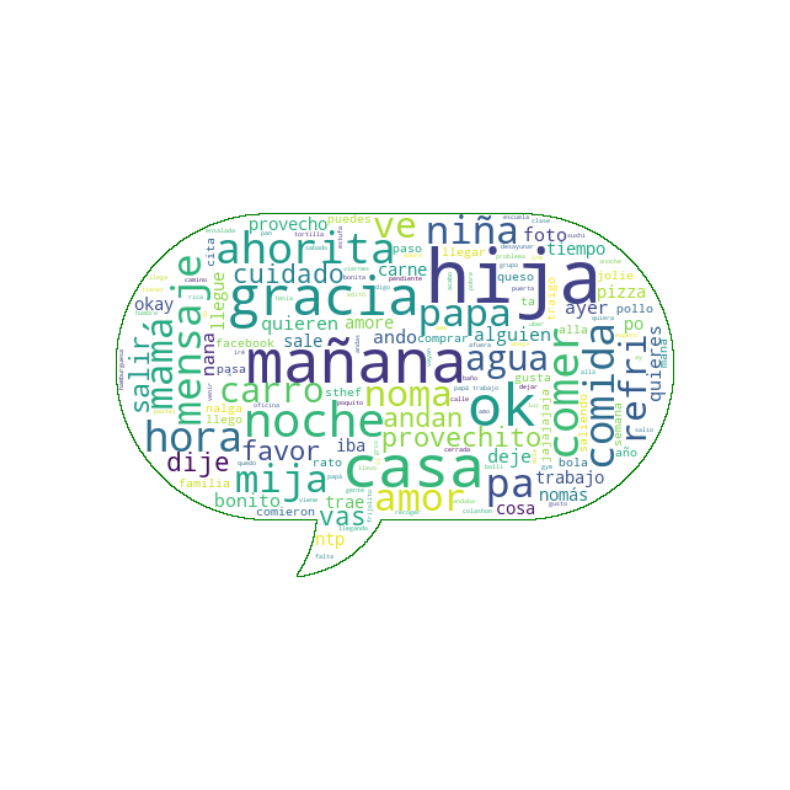

In [39]:
#Usaremos las librerias spacy y wordcloud
import spacy
import wordcloud
from wordcloud import WordCloud

#Creamos un solo texto a partir de nuestra columna 'mensaje' del dataframe
texto = '\n'.join(df.mensaje.str.lower().values)

#Cargamos el modelo de lenguaje de spacy
nlp = spacy.load('es_core_news_md')
nlp.max_length = len(texto) + 100

#Procesa todo el texto con spacy
doc = nlp(texto)

# Conjunto para guardar los nombres de personas detectados en el texto
nombres_detectados = set()

# Itera sobre las nombres propios encontrados y mantiene solo las de personas ('PER')
for ent in doc.ents:
    if ent.label_ == 'PER':
        nombres_detectados.add(ent.text.lower())

#Cargamos nuestras palabras de paro con spacy
palabras_paro = nlp.Defaults.stop_words
palabras_paro.update([ "multimedia", "omitido", "https", "www", "com", "q", "eliminó", "sip", "ah", "jajaja","jajajaja"])
#Agregamos los nombres detectados en los mensajes, para mantener la anonimidad
palabras_paro.update(nombres_detectados)

# Genera la nube de palabras
wc = wordcloud.WordCloud(
    stopwords=palabras_paro,
    mask = mask,
    background_color = 'white',
    max_words = 150,
    max_font_size = 60,
    contour_width = 0.2,
    contour_color = 'green'
).generate(texto)

# Muestra la nube de palabras
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Es posible que este sea un grupo familiar (es recurrente la palabra casa, carro, papá, mamá, hija) en el que se suele hablar recurrentemente de comida, podemos observar que 'facebook' también está entre las palabras más repetidas, esto puede deberse a que compartan links de la red social o hablen constantemente de ella, de no haber quitado los nombres propios, probablemente sabriamos quiénes son las personas a las que más se busca en este grupo

## Conclusión

No cabe duda que Python en conjunto con sus librerías es una herramienta muy poderosa, que nos permite desarrollar un análisis exploratorio tan profundo como deseemos, parte fundamental de la ciencia de datos.

Este proyecto logró transformar un conjunto de datos de texto no estructurados en un dataframe estructurado y analizable. A través de técnicas de limpieza, estructuración, procesamiento de lenguaje natural y visualización, logramos obtener insights interesantes y relevantes sobre los patrones de comportamiento de un grupo de WhatsApp; quiénes hablan, de qué hablan, cuándo y cómo lo hacen, mientras se mantuvo su privacidad.

### Insights obtenidos

**Patrones de actividad**
* El grupo suele estar más activo entre 12 y 3 P.M., la hora de comida
* Tiene menor actividad en fines de semana, de ser correcto que esta es una familia, es posible que se vean más los fines de semana y por ello no se comuniquen tanto por mensaje esos días
* En los meses de julio-septiembre suele haber más actividad 
* Se suelen enviar mensajes más largos a lass 2 A.M. - hora de fiestas, reuniones sociales o insomnio
* En el transcurso de los años, la actividad del grupo ha aumentado, lo que podría indicar una mayor unión entre sus miembros

**Comportamiento individual de los miembros**
* Hay dos miembros clave (Severus Snape y Hermione Granger) que mantienen el grupo activo principalmente pues envian más mensaje que los otros miembros que suelen interactuar menos.
* Hay un miembro (Severus Snape) que suele enviar más multimedia en proporción que mensajes, mientras que los otros miembros suelen envíar más mensajes de texto, es posible que Severus sea el estimulador de la conversación constantemente.

**Temas recurrentes**
* Las palabras más utilizadas son en gran parte comidas o algo relacionado a comida (refri, verbo comer, la expresión 'provecho'), se puede definir como el interés principal del grupo

### Trabajo a futuro
* Dentro del mismo análisis, sería interesante aplicar un análisis de sentimientos a los mensajes, para conocer cuál es el humor general del grupo.
* Esto se podría aplicar a proyectos de investigación del comportamiento humano si lo aplicamos a diferentes grupos de personas acorde a su edad, género, ubicación, etc., o incluso a análisis de redes sociales.